# Analyse exploratoire des données des 1000 meilleurs films selon IMDB 

Nous allons analyser puis classé les sentiments des avis sur les films 

plan :

1. Analyse exploratoire des données 
2. Analyse des sentiments
3. classification des sentiments (Machine Learning & Deep learning )


In [77]:
# library 
import os  
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

from pathlib import Path
sns.set_theme(style="whitegrid", palette="pastel")
from matplotlib import rcParams

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



## Importation des données

In [51]:
BASE_DIR = Path().resolve().parent
DATA_DIR = BASE_DIR / 'Data' 

#print(f"BASE_DIR: {BASE_DIR}")
#print(f"DATA_DIR: {DATA_DIR}")

# import des données 
df = pd.read_csv(DATA_DIR / 'Top_1000_IMDb_movies.csv')
df.head(3)

,Unnamed: 0,Movie Name,Year of Release,Watch Time,Movie Rating,Metascore of movie,Gross,Votes,Description
0,0,The Shawshank Redemption,1994,142,9.3,82.0,28.34,"27,77,378","Over the course of several years, two convicts..."
1,1,The Godfather,1972,175,9.2,100.0,134.97,"19,33,588","Don Vito Corleone, head of a mafia family, dec..."
2,2,The Dark Knight,2008,152,9.0,84.0,534.86,"27,54,087",When the menace known as the Joker wreaks havo...


In [52]:
print(f"la database contient {df.shape[0]} lignes et {df.shape[1]} colonnes")
print(f"les colonnes sont : {df.columns.tolist()}")

la database contient 1000 lignes et 9 colonnes
les colonnes sont : ['Unnamed: 0', 'Movie Name', 'Year of Release', 'Watch Time', 'Movie Rating', 'Metascore of movie', 'Gross', 'Votes', 'Description']


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          1000 non-null   int64  
 1   Movie Name          1000 non-null   object 
 2   Year of Release     1000 non-null   object 
 3   Watch Time          1000 non-null   int64  
 4   Movie Rating        1000 non-null   float64
 5   Metascore of movie  845 non-null    float64
 6   Gross               838 non-null    object 
 7   Votes               1000 non-null   object 
 8   Description         1000 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 70.4+ KB


- Taille : 1000 lignes, 9 colonnes

- Colonnes avec valeurs manquantes :

    Metascore of movie : 845/1000 non-null

    Gross : 838/1000 non-null

    Types à corriger :

Year of Release, Gross, et Votes sont des object, ce qui est probablement incorrect si tu veux faire des analyses numériques ou temporelles.

In [54]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.describe() 

,unnamed:_0,watch_time,movie_rating,metascore_of_movie
count,1000.000000,1000.000000,1000.000000,845.000000
mean,499.500000,124.253000,7.970200,79.011834
std,288.819436,28.800355,0.275732,11.973800
min,0.000000,45.000000,7.600000,28.000000
25%,249.750000,103.000000,7.800000,71.000000
50%,499.500000,120.000000,7.900000,80.000000
75%,749.250000,139.000000,8.100000,88.000000
max,999.000000,321.000000,9.300000,100.000000


`watch_time` (durée du film) :
- Moyenne : 124 min → des films classiques en termes de durée.
- Minimum : 45 min → peut-être un documentaire ou un court-métrage.
- Maximum : 321 min → ça c’est long ! Peut-être un film très spécial ou un problème de donnée à vérifier.

`movie_rating` (note du film) :
- Notes élevées en général (entre 7.6 et 9.3), ce qui suggère une base de données avec des films bien notés.
-Écart-type faible (0.27) → les notes sont assez regroupées, peu de variation.

`metascore_of_movie` :
- Moyenne : 79 sur 100 → plutôt bon.
- Valeurs manquantes : 155 films (~15%) n’ont pas de Metascore → à gérer.

### **Analyses**

In [55]:
# suppression de la colonne inutile 'Unnamed: 0'

df = df.drop('unnamed:_0', axis=1)

#### **movie rating (Note du film)**

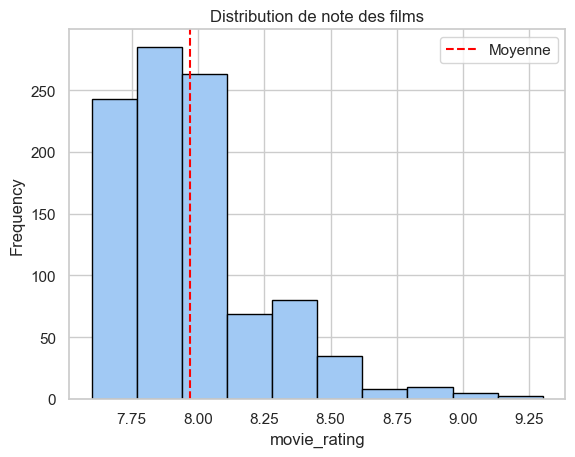

In [ ]:
plt.figure(figsize=(16,8))
plt.hist(df['movie_rating'], bins=10, edgecolor='black')
plt.axvline(df['movie_rating'].mean(), color='red', linestyle='--', label='Moyenne')
plt.legend()
plt.xlabel('movie_rating')
plt.ylabel('Frequency')
plt.title('Distribution de note des films')
plt.show()

La majorité des films ont une note entre 7.75 et 8.1.

La distribution est asymétrique à droite : peu de films au-dessus de 8.5.

#### **Diagramme de dispersion des évaluations de films par rapport à la valeur brute**

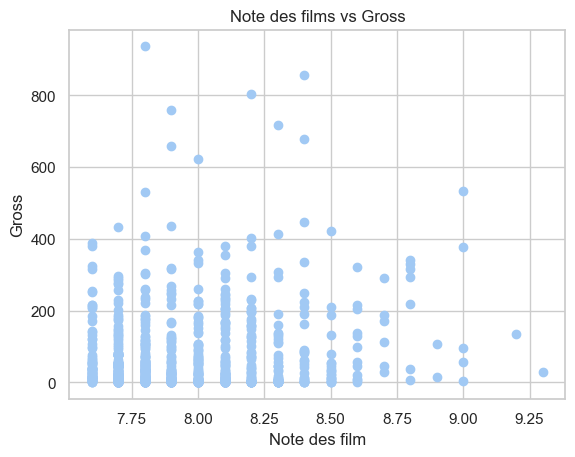

In [ ]:
df['gross'] = pd.to_numeric(df['gross'].str.replace(',', ''), errors='coerce')

plt.figure(figsize=(16,8))
plt.scatter(df['movie_rating'], df['gross'])
plt.xlabel('Note des film')
plt.ylabel('Gross')
plt.title('Note des films vs Gross')
plt.show()

Pas de vraie corrélation visuelle forte entre la note et le box-office (Gross).

Des films très bien notés (> 8.5) peuvent avoir un faible revenu, et inversement.

Certains films autour de 8.0–8.3 ont généré beaucoup de revenus (> 800), ce qui est intéressant.

#### **Films sortis par intervalles de 5 ans**

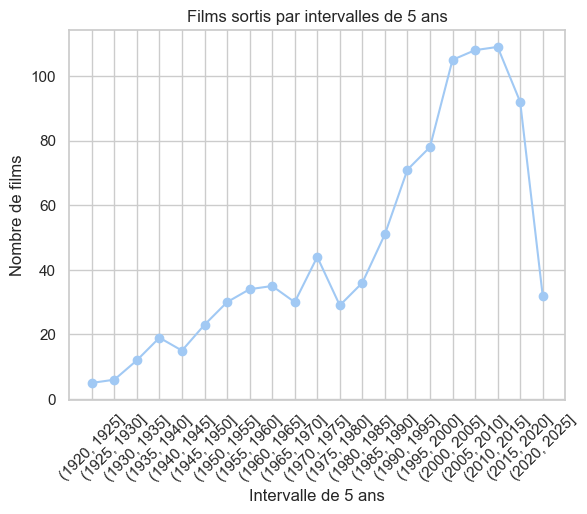

In [ ]:
df['year_of_release'] = pd.to_numeric(df['year_of_release'], errors='coerce')

# Create a new column for 5-year intervals
df['year_interval'] = pd.cut(df['year_of_release'], bins=range(int(df['year_of_release'].min()), int(df['year_of_release'].max()) + 6, 5))

# Comptez le nombre de films sortis dans chaque intervalle. 
interval_movie_count = df.groupby('year_interval')['movie_name'].count()

# Convertir les étiquettes des intervalles en chaînes de caractères 
interval_movie_count.index = interval_movie_count.index.astype(str)

# Créer un graphique linéaire pour le nombre de films sur des intervalles de 5 ans 

plt.figure(figsize=(16,8))
plt.plot(interval_movie_count.index, interval_movie_count.values, marker='o')
plt.xlabel('Intervalle de 5 ans')
plt.ylabel('Nombre de films')
plt.title('Films sortis par intervalles de 5 ans')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


**Tendance historique**:
- Une croissance lente jusqu'aux années 1970–1980.
- Puis une accélération continue jusque 2010–2015, avec un pic autour de 2005–2015 (~105 films sur 5 ans).
- Ensuite, une chute nette entre 2015–2025, probablement liée à :

Un effet de bord du dataset (il est possible que les films les plus récents n’aient pas encore assez de recul pour être classés haut)

Ou bien à la période COVID impactant la production/distribution.

#### **Distribution des évaluations de films par intervalles de 5 ans**

C:\Users\NAZIFOU\AppData\Local\Temp\ipykernel_21940\133623191.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=df['year_interval'].unique())


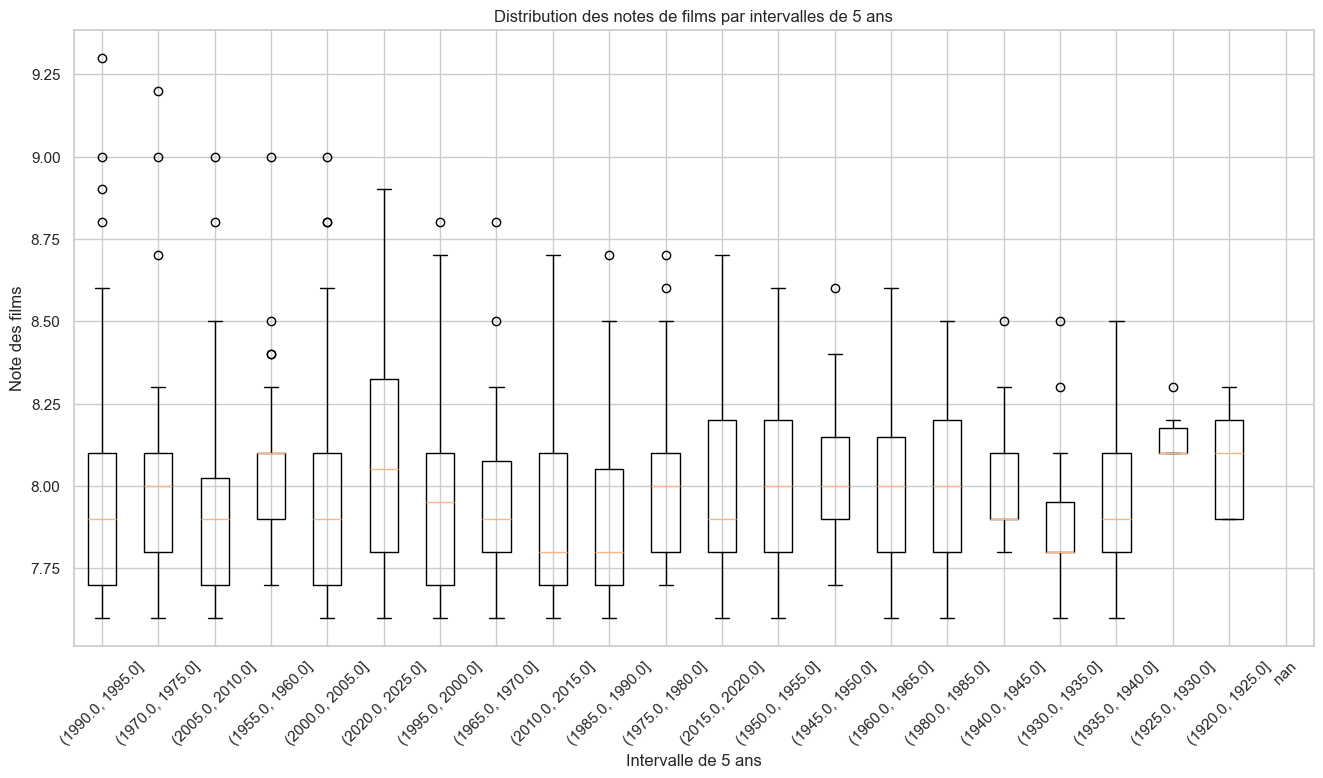

In [62]:
df = df.dropna(subset=['year_of_release'])

# Convertir l'année de publication en valeur numérique pour les calculs
df['year_of_release'] = pd.to_numeric(df['year_of_release'], errors='coerce')

# Créer une nouvelle colonne pour les intervalles de 5 ans
df['year_interval'] = pd.cut(df['year_of_release'], bins=range(int(df['year_of_release'].min()), int(df['year_of_release'].max()) + 6, 5))

# Créer une figure et des axes
plt.figure(figsize=(16, 8))

# Liste pour stocker les données du diagramme en boîte pour chaque intervalle
boxplot_data = []

# Boucle sur chaque intervalle de 5 ans
for interval in df['year_interval'].unique():
    interval_data = df[df['year_interval'] == interval]['movie_rating']
    boxplot_data.append(interval_data)
    
# Graphique 

plt.boxplot(boxplot_data, labels=df['year_interval'].unique())

plt.xlabel('Intervalle de 5 ans')
plt.ylabel('Note des films')
plt.title('Distribution des notes de films par intervalles de 5 ans')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Notes globalement stables** :
- La médiane des notes tourne autour de 7.9 à 8.1 sur presque tous les intervalles.
- Aucune période ne ressort de manière extraordinairement haute ou basse.

**Quelques pics intéressants** :
- 1930–1950 semble contenir des films très bien notés (plusieurs outliers > 9).
- 1990–1995 et 2000–2005 ont une bonne médiane et quelques films très bien notés.

Un léger fléchissement récent ?
- Les intervalles 2010–2020 affichent une médiane un tout petit peu plus basse.

À croiser avec ton observation précédente : le Metascore baisse aussi dans les années récentes.



#### **Distribution de la durée de visionnage des films**

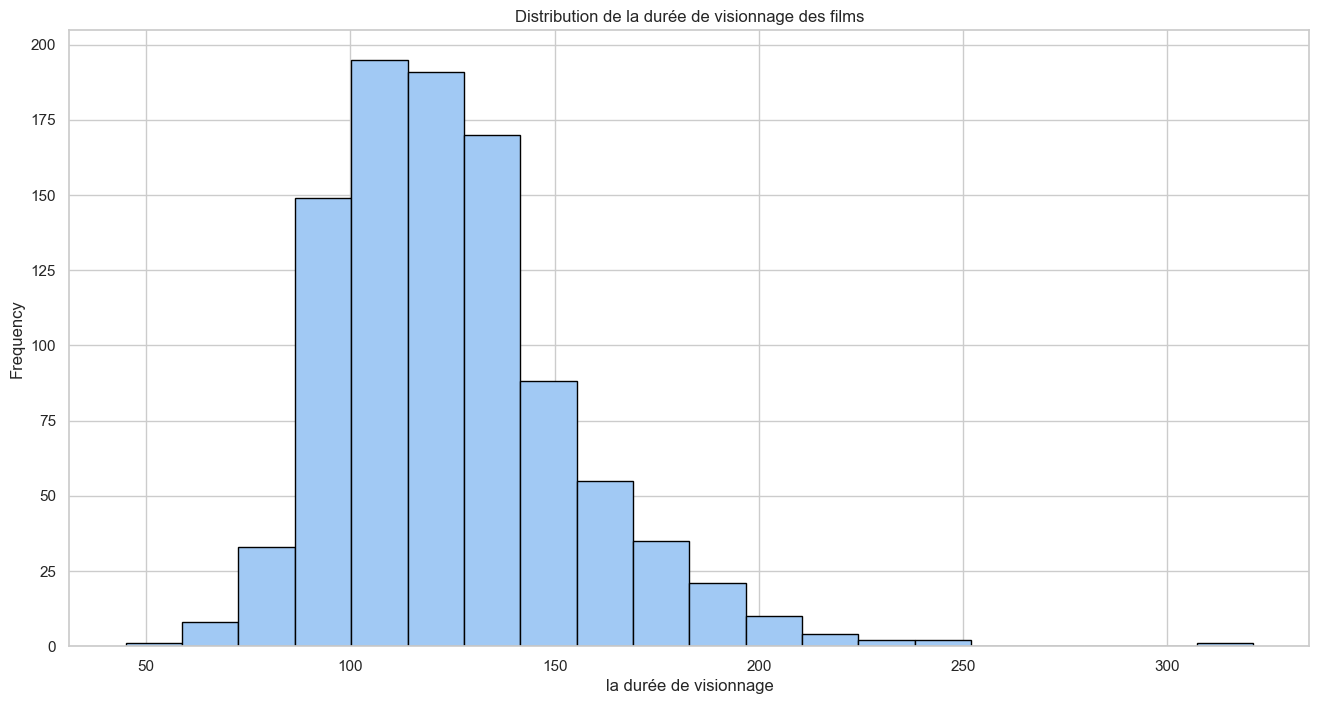

In [66]:
plt.figure(figsize=(16, 8))
plt.hist(df['watch_time'], bins=20, edgecolor='black')
plt.xlabel('la durée de visionnage')
plt.ylabel('Frequency')
plt.title('Distribution de la durée de visionnage des films')
plt.show()

on observe :

    - Distribution en forme de cloche légèrement asymétrique, centrée autour de 100–130 minutes.
    - La majorité des films durent entre 90 et 150 minutes, ce qui est très classique.
    -Très peu de films très courts (< 60 min) ou très longs (> 180 min).

Il y a quelques valeurs extrêmes (outliers) vers 250+ min, à garder en tête pour une éventuelle normalisation ou nettoyage plus tard.

#### **Évaluation agrégée vs Metascore**

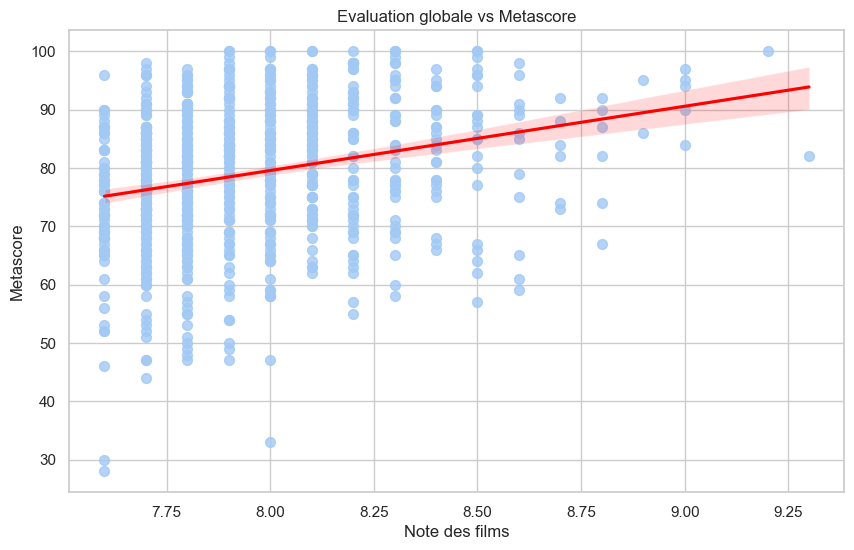

In [68]:
df = df.dropna(subset=['metascore_of_movie'])

# Graphique de la distribution de la note Metascore
plt.figure(figsize=(10, 6))
sns.regplot(x='movie_rating', y='metascore_of_movie', data=df, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.xlabel('Note des films')
plt.ylabel('Metascore')
plt.title('Evaluation globale vs Metascore')
plt.grid(True)
plt.show()

Corrélation positive visible (et confirmée par la droite rouge de régression).

Plus un film est bien noté par le public, plus il a de chances d’avoir un bon Metascore (critique presse).

Mais : il y a tout de même de la dispersion → certains films très bien notés n’ont pas un Metascore élevé, et inversement.

#### **Distribution des évaluations de films**

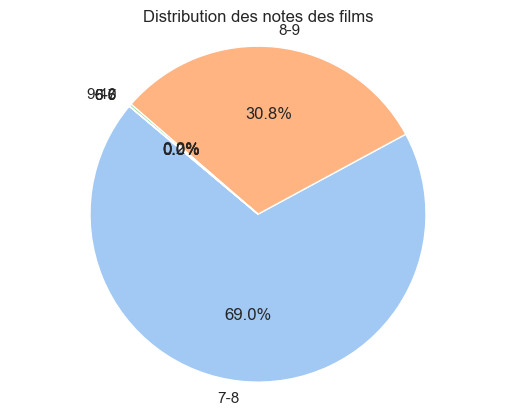

In [69]:
rating_bins = [0, 5, 6, 7, 8, 9, 10]
rating_labels = ['0-5', '5-6', '6-7', '7-8', '8-9', '9-10']
rating_distribution = pd.cut(df['movie_rating'], bins=rating_bins, labels=rating_labels)
plt.pie(rating_distribution.value_counts(), labels=rating_distribution.value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution des notes des films')
plt.axis('equal')
plt.show()

- 69% des films ont une note entre 7 et 8 → donc majorité des films "bons", sans être excellents.
- 30.8% ont une note entre 8 et 9 → les très bons films.
- Les films notés en dessous de 7 ou au-dessus de 9 sont quasi absents

#### **Nombre cumulé de films au fil des ans**

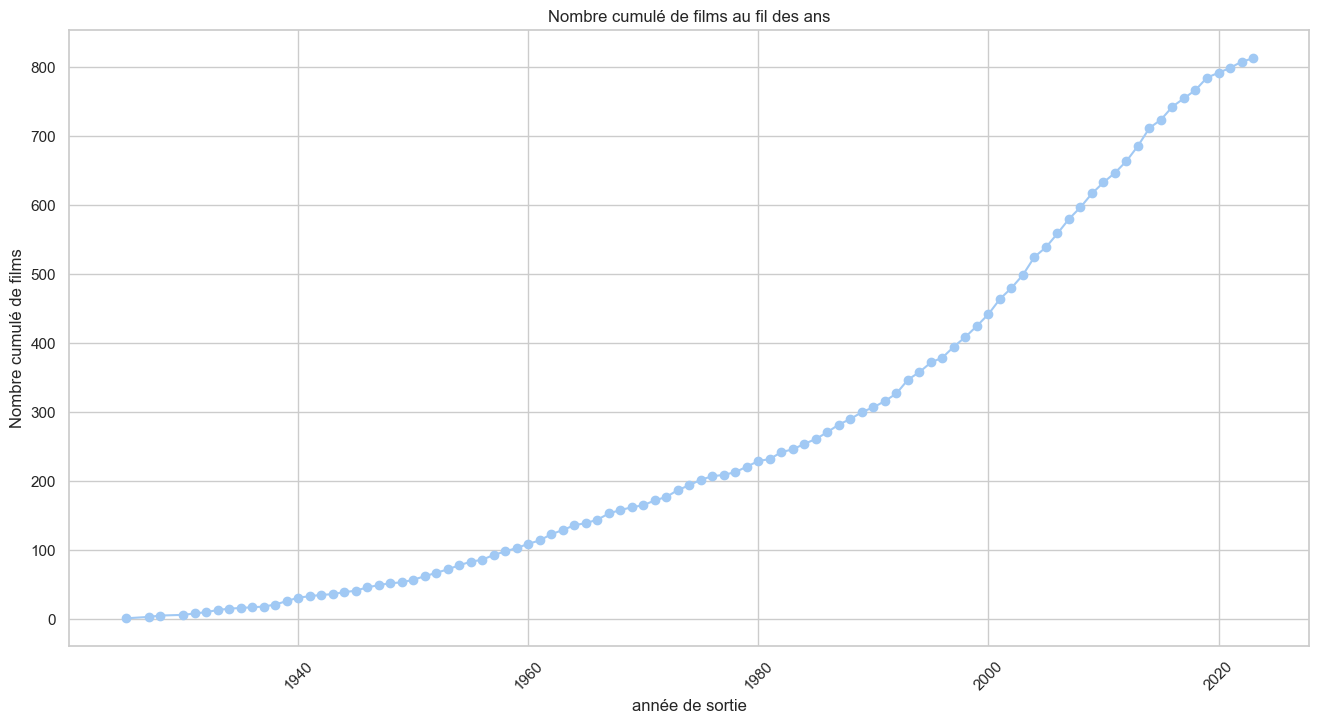

In [71]:
year_count = df['year_of_release'].value_counts().sort_index().cumsum()
plt.figure(figsize=(16, 8)) 
plt.plot(year_count.index, year_count.values, marker='o')
plt.xlabel('année de sortie') 
plt.ylabel('Nombre cumulé de films')
plt.title('Nombre cumulé de films au fil des ans')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

On voit une accélération nette à partir des années 2000, avec une croissance bien plus rapide du nombre de films.

Jusqu'aux années 80–90, la croissance est plus linéaire.

Vers 2020, la courbe ralentit un peu → peut-être à cause de la pandémie ou du dataset limité aux meilleures notes ?

#### **évaluation des films en fonction de la durée de visionnage**

C:\Users\NAZIFOU\AppData\Local\Temp\ipykernel_21940\3913854039.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['watch_time_range'] = pd.cut(df['watch_time'], bins=watch_time_bins, labels=watch_time_labels)


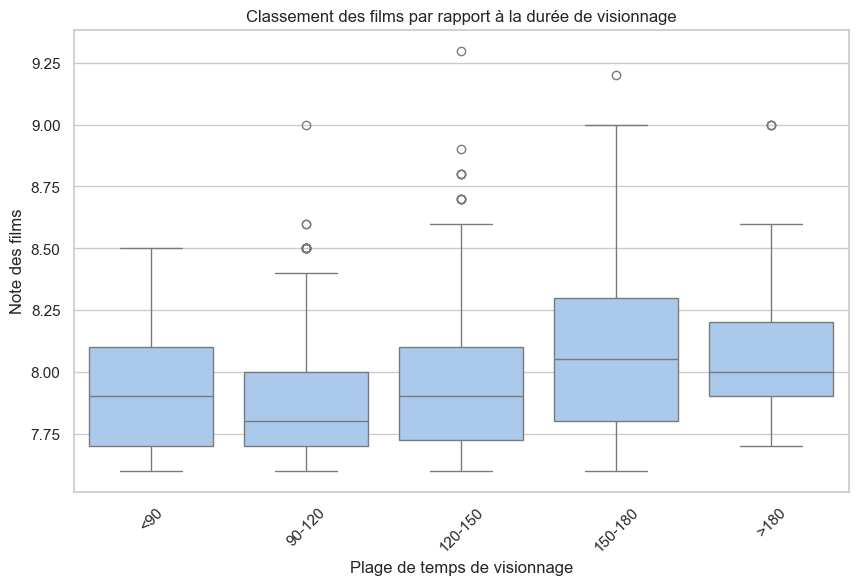

In [72]:
watch_time_bins = [0, 90, 120, 150, 180, float('inf')]
watch_time_labels = ['<90', '90-120', '120-150', '150-180', '>180']
df['watch_time_range'] = pd.cut(df['watch_time'], bins=watch_time_bins, labels=watch_time_labels)
plt.figure(figsize=(10, 6))
sns.boxplot(x='watch_time_range', y='movie_rating', data=df)
plt.xlabel('Plage de temps de visionnage')
plt.ylabel('Note des films') 
plt.title('Classement des films par rapport à la durée de visionnage')
plt.xticks(rotation=45)
plt.show()

- Les films entre 150–180 minutes ont la médiane de note la plus haute, avec plusieurs outliers très bien notés.
- Les films courts (<90 min) et ceux entre 90–120 min ont des notes un peu plus basses en moyenne.
- Les films très longs (>180) ne se démarquent pas tant que ça, mais ont un score médian quand même au-dessus de 8.

Les films plus longs ont tendance à être mieux notés, mais pas forcément de manière extrême. Peut-être parce qu’ils prennent plus de temps pour développer l’histoire, ou qu’ils sont souvent plus "ambitieux" ?

#### **Relations à variables multiples**

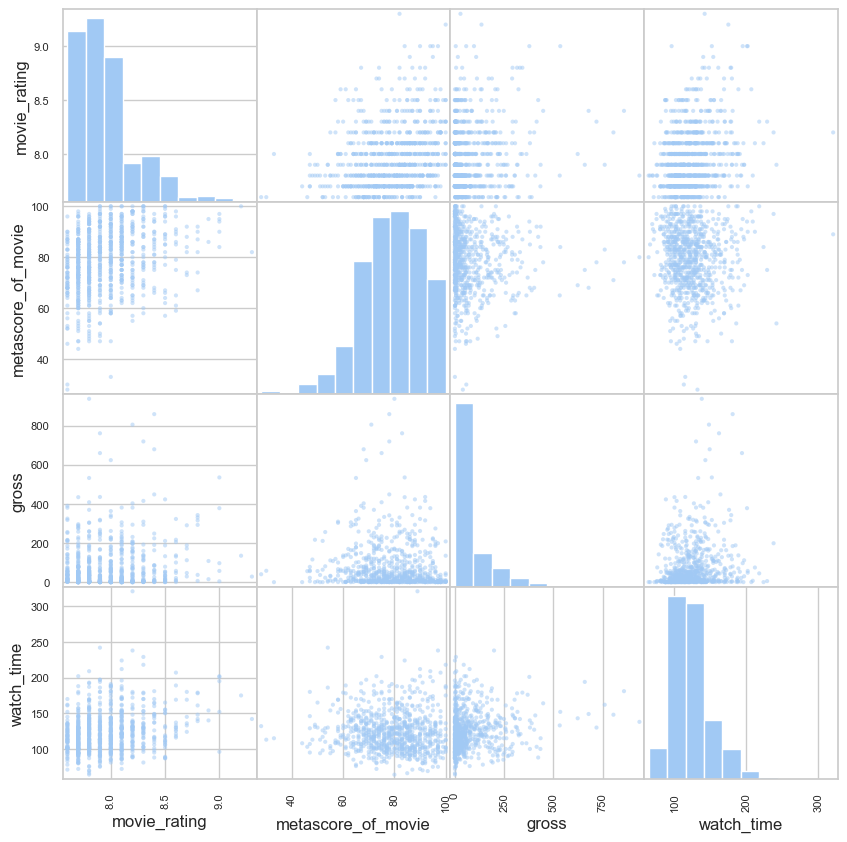

In [73]:
from pandas.plotting import scatter_matrix
scatter_matrix(df[['movie_rating', 'metascore_of_movie', 'gross', 'watch_time']], figsize=(10, 10))
plt.show()

**movie_rating vs metascore_of_movie**
Corrélation visible, positive (confirmée visuellement comme dans ton graphe précédent).

**gross vs tout le reste** :
Aucune relation claire avec les autres variables → très dispersé.

Peut être influencé par des facteurs non présents ici (marketing, distribution, acteur, etc.).

**watch_time** :
Pas de lien flagrant avec la note ni le revenu.

Mais un petit nuage concentré entre 90 et 150 minutes → durée standard.


#### **Correlation**

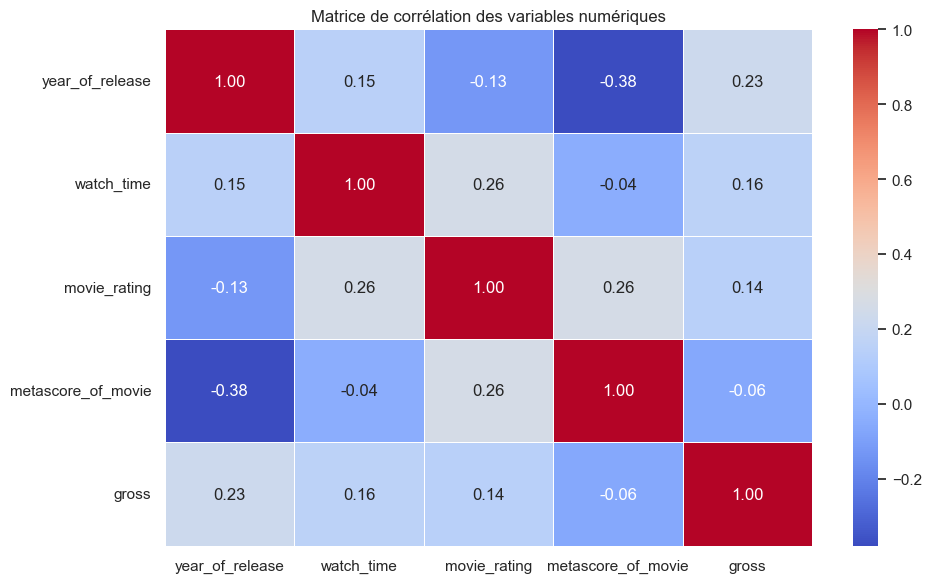

In [78]:

numerical_df = df.select_dtypes(include=['int64', 'float64'])

correlation_matrix = numerical_df.corr()

# heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Matrice de corrélation des variables numériques")
plt.tight_layout()
plt.show()

| Variables                                | Corrélation  | Interprétation                                                                                  |
|-----------------------------------------:|-------------:|------------------------------------------------------------------------------------------------:|
| `movie_rating` & `metascore_of_movie`    | **0.26**     | Corrélation positive modérée : les films bien notés par le public plaisent aussi à la critique. |
| `watch_time` & `movie_rating`            | **0.26**     | Les films plus longs ont tendance à être un peu mieux notés.                                    |
| `year_of_release` & `metascore_of_movie` | **-0.38**    | Les films récents ont tendance à avoir un Metascore plus bas.                                   |
| `year_of_release` & `gross`              | **0.23**     | Les films récents génèrent un peu plus de revenus en moyenne.                                   |
| `gross` & `movie_rating`                 | **0.14**     | Très faible lien : un bon film ne fait pas forcément un gros box-office.                        |
| `watch_time` & `metascore_of_movie`      | **-0.04**    | Corrélation négligeable entre durée et avis critique.                                           |
| `gross` & `metascore_of_movie`           | **-0.06**    | Aucun lien significatif entre critiques presse et revenus.                                      |


**Conclusion**

L’analyse exploratoire menée sur ce dataset de 1000 films a permis de dégager plusieurs tendances intéressantes autour des notes, durées, revenus, et époques de sortie :

**Notes globalement élevées et concentrées**
- La majorité des films sont notés entre 7.5 et 8.5, avec une médiane autour de 8.0.
- Peu de films avec des notes extrêmes, ce qui indique un niveau globalement élevé de la sélection.

**Corrélations faibles mais révélatrices**
- La note publique (movie_rating) est légèrement corrélée au Metascore des critiques (𝜌 ≈ 0.26).
- Les revenus (gross) ne sont pas fortement liés à la note ni au Metascore → un bon film n’est pas forcément un succès commercial.
- Une durée plus longue est associée à une note un peu plus élevée.

**Évolution dans le temps**
- Le nombre de films sortis augmente fortement à partir des années 90, avec un pic entre 2005 et 2015.
- Cependant, les notes ne suivent pas cette croissance → la quantité ne rime pas toujours avec qualité.
- Les Metascores semblent en légère baisse sur les périodes les plus récentes.

**Répartition par durée**:
- Les films d’une durée standard (90–150 min) dominent largement le dataset.
- Les films entre 150–180 min tendent à obtenir les meilleures évaluations.


L’univers des films explorés ici montre une prédominance de films bien notés, mais sans lien fort avec leur succès commercial. La quantité de productions a explosé, surtout après 2000, mais la qualité perçue reste stable. Les films plus longs obtiennent en moyenne de meilleures critiques, et les films plus anciens ont parfois des notes très élevées, soulignant peut-être leur caractère culte ou leur impact historique.